In [172]:
import numpy  as np

import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma
import os
from qutip import*
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap as lsc
import time
from matplotlib.pyplot import figure, show
from matplotlib import gridspec


In [173]:
def wigner_from_char(char,dx,scale,padding=True,pad_n=1001):
    if padding:
        char_new=np.zeros((pad_n,pad_n))
        char_new[pad_n//2-char.shape[-1]//2:pad_n//2+char.shape[-1]//2+1,pad_n//2-char.shape[-1]//2:pad_n//2+char.shape[-1]//2+1]=char
    else:
        char_new=char
    center=np.zeros(np.shape(char_new))
    center[char_new.shape[-1]//2,char_new.shape[-1]//2]=1
    f=np.fft.fftfreq(char_new.shape[-1],dx)*np.pi/scale
    f=np.fft.fftshift(f)
    wig=np.fft.fft2(char_new)/np.fft.fft2(center)
    wig=np.fft.fftshift(wig)*(dx**2/np.pi**2*scale**2)
    return f,wig
def wigner_origin_from_char(char,dx,scale):
    return np.sum(char)*(dx*scale)**2/np.pi**2

In [174]:
dx=0.1
scale = 3
normal=0.9
# d_avg_key_others = [ 16,1000, 10000, 16000, 30000, 50000, 100000, 150000, 200000]
d_avg_key = [ 0,1000, 10000, 16000, 30000, 50000, 100000, 150000, 200000]

In [175]:
def find_background(data):
    def portion_sea(thresh):
        return np.sum(data>thresh)
    half=np.size(data)/2
    up,down=1.,-1.
    for i in range(100):
        val=(up+down)/2
        if portion_sea(val)>half:
            down=val
        else:
            up=val
    return up

In [176]:
from tkinter import Frame

def load_data(d1,fname,scale,normal,background=True,max_file=10):
    fps = []
    fp1 = ([d1 + f for f in os.listdir(d1) if f.endswith(fname +'.h5')])
    fp1.sort(key=lambda x: os.path.getmtime(x))
    fps = fp1
    dg = []
    de = []
    dts = []
    
    for kk in range(len(fps)):
#         fname = d + files[kk]
        df = h5py.File(fps[kk], "r")
        data = df["data"]
        data_i = data["I"][:]
        x = data["x"][:, 0, 0] * scale
        y = data["y"][0, :, 0] * scale
        dt = df.attrs['decay_time']
        thresh = 1.736310313628283e-05 #-6.687025253601604e-06

        raw_m0 = data_i[:, 0::3]
        raw_m1 = data_i[:, 1::3] 
        raw_m2 = data_i[:, 2::3]
        
        m0 = np.where(raw_m0 < thresh, 1, 0)
        m1 = np.where(raw_m1 < thresh, 1, 0)
        m2 = np.where(raw_m2 < thresh, 1, 0)
        
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)

        ## only care about last two measurements
        proj_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(len(x), len(y)) * 2 - 1
        proj_e = ma.masked_array(m2, mask=np.logical_not(m1)).mean(axis=0).reshape(len(x), len(y)) * 2 - 1

        ## condition on the first measurement as well
#         double_ps_g = ma.masked_array(m2_g, mask=m1_g).mean(axis=0).reshape(len(x), len(y)) * 2 - 1
#         double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g)).mean(axis=0).reshape(len(x), len(y)) * 2 - 1

        
        #double check
        double_ps_g = ma.masked_array(m2_g, mask=m1).mean(axis=0).reshape(len(x), len(y)) * 2 - 1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1)).mean(axis=0).reshape(len(x), len(y)) * 2 - 1

        
        dg.append(double_ps_g)
        de.append(double_ps_e)
        dts.append(dt)

    dg = np.array(dg)
    de = np.array(de)
    dts = np.array(dts)
    decay_times = np.unique(dts)//1000*1000
    dd = {}
    for dt in decay_times:
        dd[str(dt)] = []

    for n, dt in enumerate(dts):
        dd[str(dt//1000*1000)].append(dg[n])
    d_avg = {}
    d_centre = {}
    for dt in decay_times:
        data = np.array(dd[str(dt)])[:max_file,:].mean(axis=0)
        data/=normal
        if background:
            n=5
#             back=np.mean((data[0:n,0:n]+data[0:n,-n:]+data[-n:,0:n]+data[-n:,-n:])/4)
            back=find_background(data)
            data-=                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
        d_avg[str(dt)]=data
            
#         d_centre[str(dt)] = np.array(dd[str(dt)]).mean(axis=0).flatten().max()
    return x, y, d_avg

In [177]:
d1 = "Z:/lab_data/squeezed_cat/cat_data/all_data/"

In [178]:
def plot_cats(x,y,d_avg):
    rows = 1
    cols = len(d_avg_key)
    fig, axes = plt.subplots(rows, cols, figsize=(30, 20))
    for j in range(cols):
        axes[j].pcolormesh(x,x, d_avg[str(d_avg_key[j])] , cmap="seismic", shading = 'auto', vmax=1, vmin=-1)
        axes[j].set_aspect("equal")
        axes[j].set_title(str(d_avg_key[j]))

In [179]:
def calc_wigners(x,y,d_avg):
    f={}
    w_fft ={}
    for dt in d_avg_key:
        f,w_fft[str(dt)] = wigner_from_char(d_avg[str(dt)], dx, scale)
        w_fft[str(dt)]=w_fft[str(dt)].real# abandon the imag part
    return f,w_fft

In [180]:
def calc_negativity(wigners):
    negativity=[]
    for dt in d_avg_key:
        negativity.append(wigners[str(dt)].flatten().min())
    return negativity
def calc_negativity_around_origin(wigners):
    negativity=[]
    for dt in d_avg_key:
        wig=wigners[str(dt)]
        N=np.shape(wig)[0]
        print(N)
        print(wig[N//2,N//2])
        neighbors=[wig[N//2-1,N//2-1],wig[N//2-1,N//2+1],wig[N//2+1,N//2-1],wig[N//2+1,N//2+1]]
        print(neighbors)
        negativity.append(np.mean(neighbors))
    return negativity
def calc_negativity_origin(d_avg):
    negativity=[]
    for dt in d_avg_key:
        negativity.append(wigner_origin_from_char(d_avg[str(dt)], dx,scale))
    return negativity
def calc_purity(char,dx,scale):
    return np.sum(np.abs(char)**2*(dx*scale)**2)/np.pi
def calc_puritys(d_avg):
    purity=[]
    for dt in d_avg_key:
        purity.append(calc_purity(d_avg[str(dt)], dx,scale))
    return purity

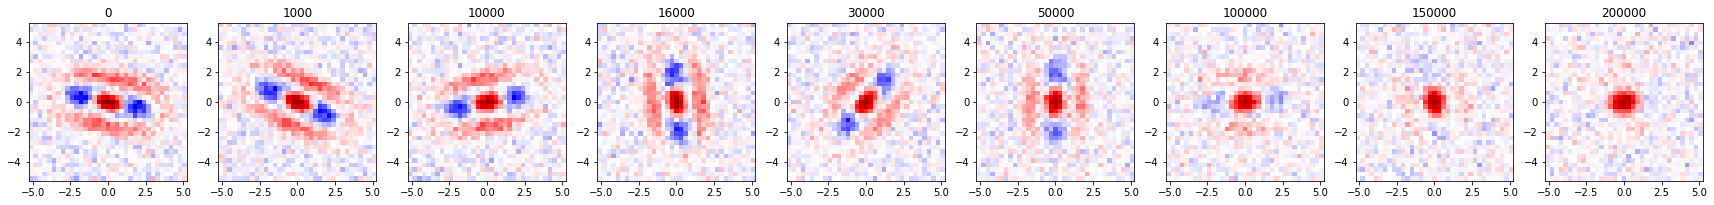

In [181]:
x, y, d_avg_7dB=load_data(d1,'panther_sq_vcat_7db',scale,normal)
plot_cats(x,y,d_avg_7dB)

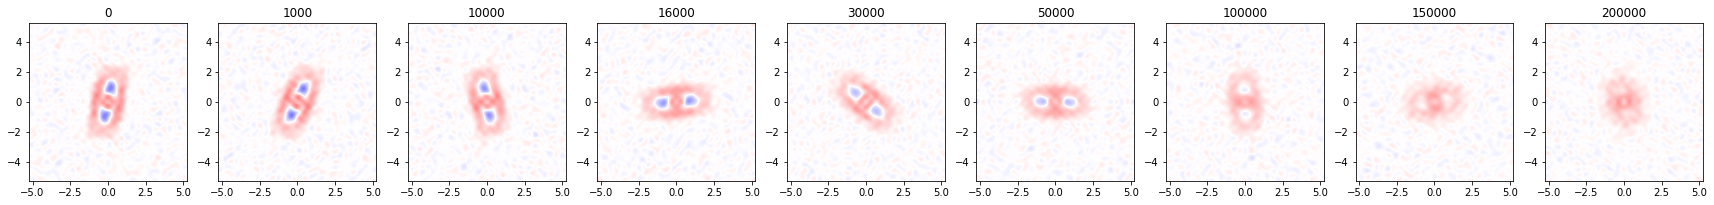

In [182]:
f,w_fft_7dB=calc_wigners(x,y,d_avg_7dB)
plot_cats(f,f,w_fft_7dB)

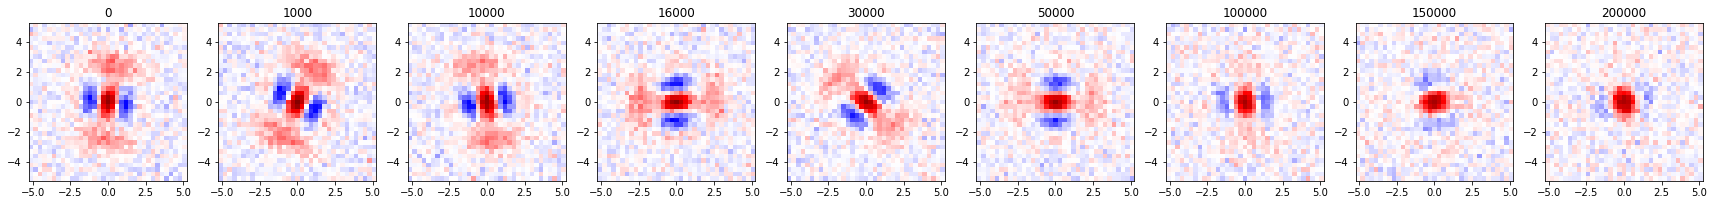

In [183]:
x, y, d_avg_3dB=load_data(d1,'panther_sq_vcat_3db',scale,normal)
plot_cats(x,y,d_avg_3dB)

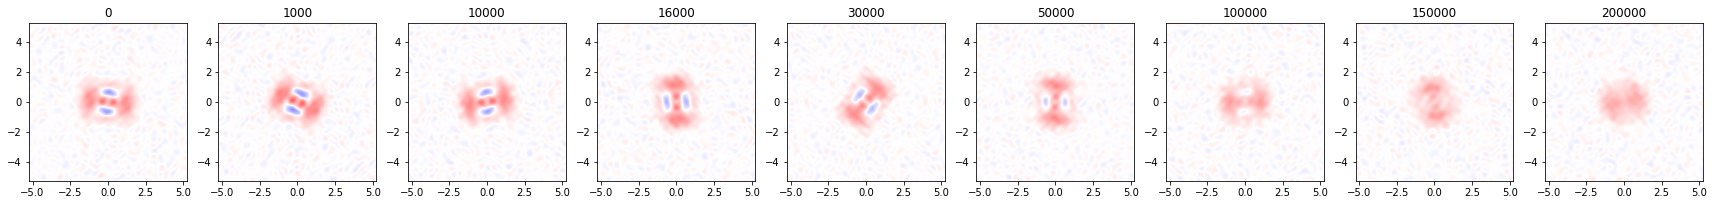

In [184]:
f,w_fft_3dB=calc_wigners(x,y,d_avg_3dB)
plot_cats(f,f,w_fft_3dB)

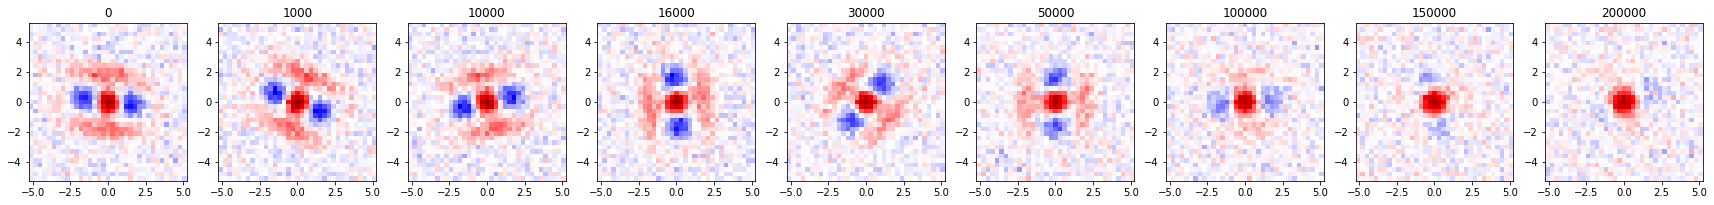

In [185]:
x, y, d_avg_6dB=load_data(d1,'panther_sq_vcat_6db',scale,normal)
plot_cats(x,y,d_avg_6dB)

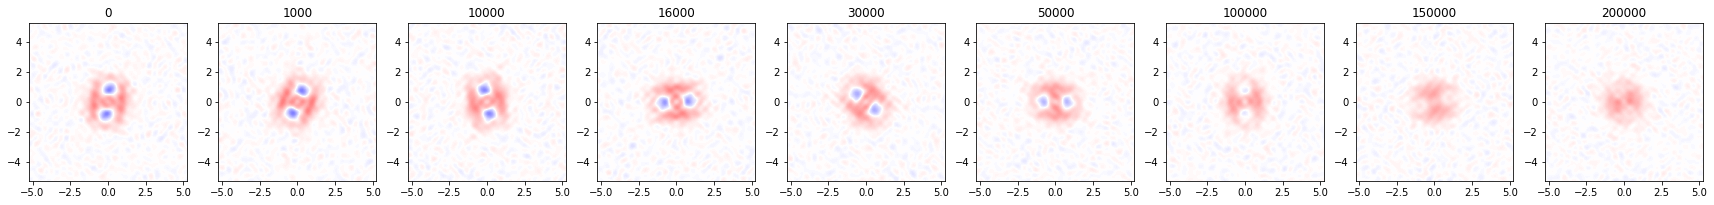

In [186]:
f,w_fft_6dB=calc_wigners(x,y,d_avg_6dB)
plot_cats(f,f,w_fft_6dB)

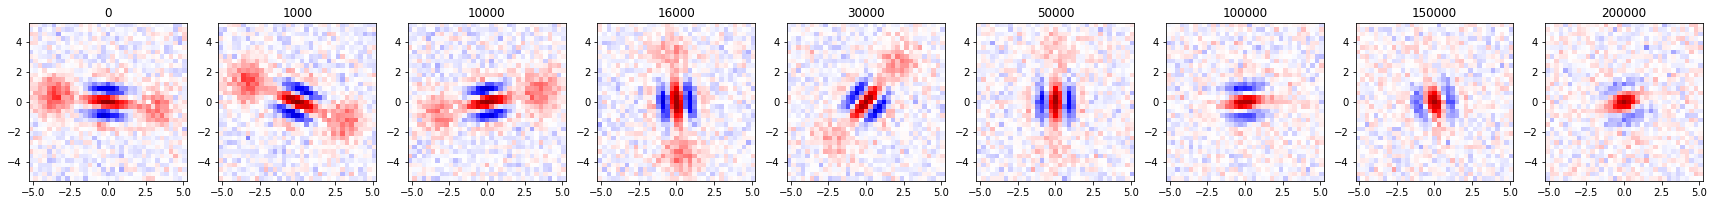

In [187]:
x, y, d_avg_0dB=load_data(d1,'normal_cat_decay',scale,normal)
plot_cats(x,y,d_avg_0dB)

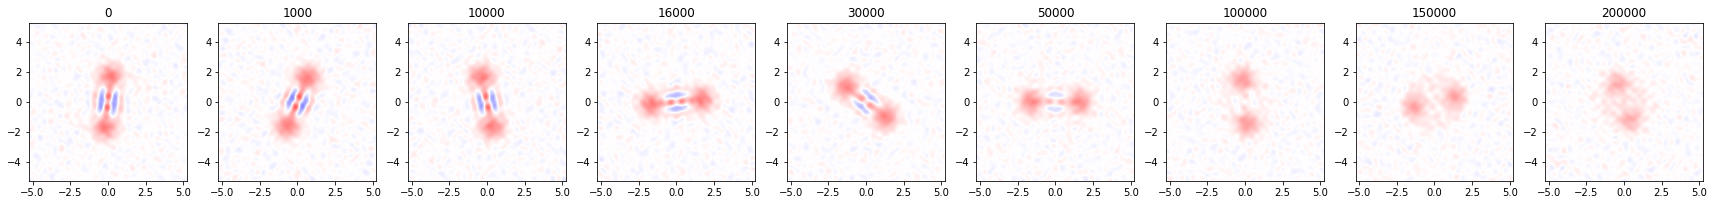

In [188]:
f,w_fft_0dB=calc_wigners(x,y,d_avg_0dB)
plot_cats(f,f,w_fft_0dB)

In [189]:
negativity_7dB=calc_negativity(w_fft_7dB)
negativity_ao_7dB=calc_negativity_around_origin(w_fft_7dB)
negativity_origin_7dB=calc_negativity_origin(d_avg_7dB)
purity_7dB=calc_puritys(d_avg_7dB)

1001
0.13524063487133736
[0.13572423270213274, 0.13553362192188548, 0.13553362192188556, 0.13572423270213266]
1001
0.13232749331471516
[0.1329763533836051, 0.13246029104278412, 0.13246029104278423, 0.132976353383605]
1001
0.11299549993087886
[0.11349396638013882, 0.11330794325463972, 0.11330794325463976, 0.11349396638013881]
1001
0.13672031030806125
[0.13698465691940362, 0.13699927548988525, 0.13699927548988536, 0.1369846569194035]
1001
0.08731172550186299
[0.0875881401448396, 0.08792881043273487, 0.08792881043273489, 0.08758814014483955]
1001
0.10565438385581626
[0.10601225720658863, 0.10587864926101657, 0.10587864926101662, 0.10601225720658862]
1001
0.12167718066289568
[0.12188506243799078, 0.12183516826564007, 0.12183516826564014, 0.12188506243799074]
1001
0.10028899696584741
[0.10051071581594563, 0.10048986726395037, 0.10048986726395041, 0.1005107158159456]
1001
0.09969254240484626
[0.10003236296081121, 0.10002018339150244, 0.1000201833915025, 0.10003236296081115]


In [190]:
negativity_3dB=calc_negativity(w_fft_3dB)
negativity_ao_3dB=calc_negativity_around_origin(w_fft_3dB)
negativity_origin_3dB=calc_negativity_origin(d_avg_3dB)
purity_3dB=calc_puritys(d_avg_3dB)

1001
0.12914819380668266
[0.12929435854840962, 0.12956519332861618, 0.12956519332861624, 0.12929435854840957]
1001
0.14502885685044806
[0.14513029586096088, 0.14567437994100624, 0.14567437994100632, 0.14513029586096082]
1001
0.12200315591746687
[0.12242244082720227, 0.12224346409713542, 0.12224346409713546, 0.1224224408272022]
1001
0.11836229542826085
[0.11862410083854705, 0.1186158805734645, 0.11861588057346457, 0.11862410083854705]
1001
0.08515140049128851
[0.08582370107108146, 0.08513935466075201, 0.08513935466075205, 0.08582370107108139]
1001
0.10468351309506985
[0.10492307209944797, 0.10494906550388257, 0.10494906550388262, 0.1049230720994479]
1001
0.08050760841168168
[0.08064639338574033, 0.08071388980415378, 0.08071388980415381, 0.0806463933857403]
1001
0.08519031494960864
[0.0852317680684006, 0.08550723893289555, 0.08550723893289561, 0.08523176806840056]
1001
0.1241621392624817
[0.12417586627172955, 0.124123074716087, 0.12412307471608706, 0.1241758662717295]


In [191]:
negativity_6dB=calc_negativity(w_fft_6dB)
negativity_ao_6dB=calc_negativity_around_origin(w_fft_6dB)
negativity_origin_6dB=calc_negativity_origin(d_avg_6dB)
purity_6dB=calc_puritys(d_avg_6dB)

1001
0.14300687985718488
[0.14336192105202525, 0.14312052555382174, 0.14312052555382188, 0.14336192105202522]
1001
0.13060385094772203
[0.13087059458592573, 0.13101059635962622, 0.1310105963596263, 0.13087059458592565]
1001
0.09135539472186327
[0.09169731210278065, 0.09180526517140457, 0.0918052651714046, 0.09169731210278059]
1001
0.08739310311170415
[0.08779722877166195, 0.08795288339751366, 0.08795288339751368, 0.08779722877166193]
1001
0.09249204036155052
[0.09274824013776796, 0.09295930675191916, 0.09295930675191921, 0.09274824013776792]
1001
0.09589387547877049
[0.09625025577857606, 0.09607396889469705, 0.09607396889469706, 0.096250255778576]
1001
0.0726178799521682
[0.07298375626275659, 0.07290126946214556, 0.0729012694621456, 0.07298375626275659]
1001
0.1023072290155723
[0.10235270166507715, 0.10243888181770147, 0.10243888181770154, 0.1023527016650771]
1001
0.11043018196763141
[0.11071811224774682, 0.11054916992304571, 0.11054916992304575, 0.1107181122477468]


In [192]:
negativity_0dB=calc_negativity(w_fft_0dB)
negativity_ao_0dB=calc_negativity_around_origin(w_fft_0dB)
negativity_origin_0dB=calc_negativity_origin(d_avg_0dB)
purity_0dB=calc_puritys(d_avg_0dB)

1001
0.13681249543908983
[0.13684666557363162, 0.1364246211854447, 0.13642462118544482, 0.13684666557363154]
1001
0.13150016521629304
[0.13212330357568597, 0.13076929644896315, 0.13076929644896318, 0.13212330357568589]
1001
0.10914653924394647
[0.10867206279022801, 0.10952233666847487, 0.10952233666847491, 0.10867206279022795]
1001
0.07692652306261402
[0.0770903632713206, 0.07686553661493102, 0.07686553661493106, 0.07709036327132054]
1001
0.06550889425169626
[0.06504854228643331, 0.06607026195589631, 0.06607026195589635, 0.06504854228643328]
1001
0.038637119312323914
[0.03871373102243107, 0.03878644542409197, 0.03878644542409198, 0.03871373102243107]
1001
-0.0002532995553767367
[-1.1721527512757654e-05, -8.515726746433517e-05, -8.515726746435105e-05, -1.1721527512741437e-05]
1001
0.018373888681748496
[0.018579210100244697, 0.01838969627784991, 0.018389696277849907, 0.018579210100244693]
1001
0.0726738483312655
[0.07256127727616164, 0.07252165937234564, 0.07252165937234568, 0.0725612772

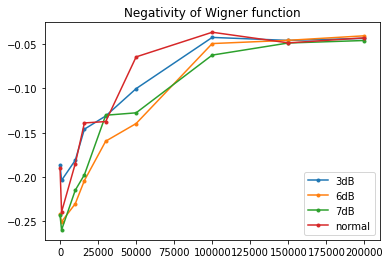

In [193]:
fig, ax =plt.subplots()
ax.plot(d_avg_key, negativity_3dB, '.-',label = '3dB')
ax.plot(d_avg_key, negativity_6dB, '.-',label = '6dB')
ax.plot(d_avg_key, negativity_7dB,'.-', label = '7dB')
ax.plot(d_avg_key, negativity_0dB, '.-',label = 'normal')
ax.set_xlabel('')
ax.set_title('Negativity of Wigner function')
plt.legend()

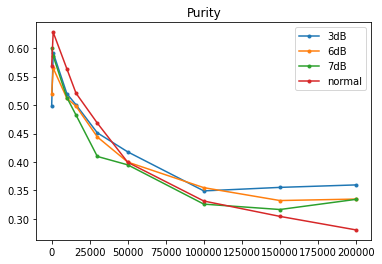

In [194]:
fig, ax =plt.subplots()
ax.plot(d_avg_key, purity_3dB, '.-',label = '3dB')
ax.plot(d_avg_key, purity_6dB, '.-',label = '6dB')
ax.plot(d_avg_key, purity_7dB,'.-', label = '7dB')
ax.plot(d_avg_key, purity_0dB, '.-',label = 'normal')
ax.set_xlabel('')
ax.set_title('Purity')
plt.legend()

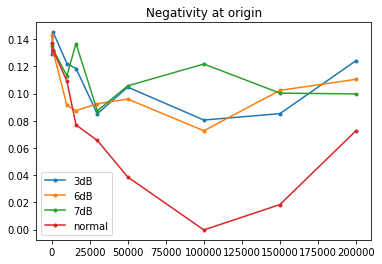

In [195]:
fig, ax =plt.subplots()
ax.plot(d_avg_key, negativity_origin_3dB, '.-',label = '3dB')
ax.plot(d_avg_key, negativity_origin_6dB, '.-',label = '6dB')
ax.plot(d_avg_key, negativity_origin_7dB,'.-', label = '7dB')
ax.plot(d_avg_key, negativity_origin_0dB, '.-',label = 'normal')
ax.set_xlabel('')
ax.set_title('Negativity at origin')
plt.legend()

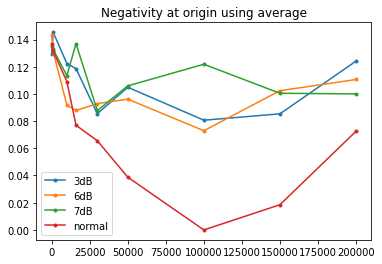

In [196]:
fig, ax =plt.subplots()
ax.plot(d_avg_key, negativity_ao_3dB, '.-',label = '3dB')
ax.plot(d_avg_key, negativity_ao_6dB, '.-',label = '6dB')
ax.plot(d_avg_key, negativity_ao_7dB,'.-', label = '7dB')
ax.plot(d_avg_key, negativity_ao_0dB, '.-',label = 'normal')
ax.set_xlabel('')
ax.set_title('Negativity at origin using average')
plt.legend()